# Class for meteorological data handling
Developing processes of classes aiming to create ther class files to be invoked.<br>
- （財）気象業務支援センター「気象データベース」の図化解析用に開発しているが，pandas DataFrameを活用することで，Classの汎用化を目指す
- 現在のところ，「地上観測」のみに対応している．「アメダス」は今後対応する予定である
- 1991年以降は毎時データで全天日射量あり（一部観測所のみ），1990年以前は3時間データで全天日射量，日照時間，降水量がない
- GWO時別値には欠損値が存在していることが判明したので，それをチェックするための`class Met_GWO_check`を作成した
#### Author: Jun Sasaki, Coded on Sep. 9, 2017, Revised on March 23, 2019
## 課題： 1990年以前の3時間データと全天日射量対応，アメダスデータ対応
1990年以前と1991年以降を同時に読み込むことは可能だが，時間間隔が異なる．任意の時間間隔にリサンプリングできるようにする．<br>
全天日射や欠損値への対応を検討する．<br>
RMKが2の場合は0の値が入っているようであるが，このままでよいか要検討．全天日射では2は夜間に相当するので，0とするのでよい．

In [1]:
import sys
#import os
import glob
import numpy as np
import math
import pandas as pd
import datetime
import subprocess
from pandas.tseries.offsets import Hour
from dateutil.parser import parse
#import json  # json cannot manipulate datetime
from matplotlib import pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
from matplotlib.dates import date2num, YearLocator, MonthLocator, DayLocator, DateFormatter

%matplotlib inline

In [2]:
class Met:
    '''気象データベース・地上観測DVD，アメダスDVDの時系列データ抽出
  +--------+------------------------------------------------------------+
  |リマーク|            解                                  説          |
  +--------+------------------------------------------------------------+
  |   ０   |観測値が未作成の場合                                        |
  +--------+------------------------------------------------------------+
  |   １   |欠測                                                        |
  +--------+------------------------------------------------------------+
  |   ２   |観測していない場合                                          |
  +--------+------------------------------------------------------------+
  |   ３   |日の極値が真の値以下の場合，該当現象がない推定値の場合      |
  +--------+------------------------------------------------------------+
  |   ４   |日の極値が真の値以上の場合，該当現象がない地域気象観測データ|
  |        |を使用する場合                                              |
  +--------+------------------------------------------------------------+
  |   ５   |推定値が含まれる場合，または２４回平均値で欠測を含む場合    |
  +--------+------------------------------------------------------------+
  |   ６   |該当する現象がない場合（降水量，日照時間，降雪，積雪，最低海|
  |        |面気圧）                                                    |
  +--------+------------------------------------------------------------+
　|   ７ 　|日の極値の起時が前日の場合　　　　　　　　　　　　　　　　　|
　+--------+------------------------------------------------------------+
　|   ８ 　|正常な観測値　　　　　　　　　　　　　　　　　　　　　　　　|
　+--------+------------------------------------------------------------+
  |   ９   |日の極値の起時が翌日の場合，または１９９０年までの８０型地上|
  |        |気象観測装置からの自動取得値                                |
  +--------+------------------------------------------------------------+
  '''
    rmk = {"0":"観測値が未作成の場合", "1": "欠測", "2":"観測していない場合", \
           "3":"日の極値が真の値以下の場合，該当現象がない推定値の場合", \
           "4":"日の極値が真の値以上の場合，該当現象がない地域気象観測データを使用する場合", \
           "5":"推定値が含まれる場合，または２４回平均値で欠測を含む場合", \
           "6":"該当する現象がない場合（降水量，日照時間，降雪，積雪，最低海面気圧）", \
           "7":"日の極値の起時が前日の場合", "8":"正常な観測値", \
           "9":"日の極値の起時が翌日の場合，または１９９０年までの８０型地上気象観測装置からの自動取得値"}
    nan_0_1_RMK = [0, 1, 2]
    def __init__(self, datetime_ini, datetime_end, stn, dir):
        self.datetime_ini = parse(datetime_ini)
        self.datetime_end = parse(datetime_end)
        print("Initial datetime = ", self.datetime_ini)
        print("End datetime = ", self.datetime_end)
        self.stn = stn
        self.dir = dir

    def set_missing_values(self, df, rmk_cols, rmk_nans):
        '''DataFrame dfを入力し，RMK列が欠損値条件を満たす行の一つ前の列の値をnp.nanに置換する'''
        ### rmk_cols = [col for col in df.columns if 'RMK' in col]  ### RMK列名のリスト
        for rmk_col in rmk_cols:
            for rmk_nan in rmk_nans:
                idx = df.columns.get_loc(rmk_col) - 1  ### RMKに対応する値の列インデックス
                df.iloc[:, idx].mask(df[rmk_col] == rmk_nan, np.nan, inplace=True)
        return df

## class Met_GWO 気象データベース・地上観測 時別値

In [3]:
class Met_GWO(Met):
    '''気象データベース・地上観測DVDの時別値（1990年以前は3時間間隔）データ抽出
       Directory name is suppoed to be stn + "/", file name supposed to be stn + year + ".csv"'''
    col_names_jp = ["観測所ID","観測所名","ID1","年","月","日","時", \
                    "現地気圧(0.1hPa)","ID2","海面気圧(0.1hPa)","ID3", \
                    "気温(0.1degC)","ID4","蒸気圧(0.1hPa)","ID5", \
                    "相対湿度(%)","ID6","風向(1(NNE)～16(N))","ID7","風速(0.1m/s)","ID8", \
                    "雲量(10分比)","ID9","現在天気","ID10","露天温度(0.1degC)","ID11", \
                    "日照時間(0.1時間)","ID12","全天日射量(0.01MJ/m2/h)","ID13", \
                    "降水量(0.1mm/h)","ID14"]
    col_names = ["KanID","Kname","KanID_1","YYYY","MM","DD","HH","lhpa","lhpaRMK", \
                 "shpa","shpaRMK","kion","kionRMK","stem","stemRMK","rhum","rhumRMK", \
                 "muki","mukiRMK","sped","spedRMK","clod","clodRMK","tnki","tnkiRMK", \
                 "humd","humdRMK","lght","lghtRMK","slht","slhtRMK","kous","kousRMK"]
    col_items_jp = ["現地気圧(hPa)","海面気圧(hPa)", \
                    "気温(degC)","蒸気圧(hPa)", \
                    "相対湿度(0-1)","風向(0-360)","風速(m/s)", \
                    "雲量(0-1)","現在天気","露天温度(degC)", \
                    "日照時間(時間)","全天日射量(W/m2)", \
                    "降水量(mm/h)","風速u(m/s)","風速v(m/s)"]
    col_items =  ["lhpa", \
                  "shpa","kion","stem","rhum", \
                  "muki","sped","clod","tnki", \
                  "humd","lght","slht","kous","u","v"]

    def __init__(self, datetime_ini = "2014-1-10 15:00:00", datetime_end = "2014-6-1 00:00:00", \
                 stn = "Tokyo", dir = "../../../met/GWO/"):
        super().__init__(datetime_ini, datetime_end, stn, dir)

        self.names_jp = Met_GWO.col_names_jp
        self.names = Met_GWO.col_names
        self.items_jp = Met_GWO.col_items_jp
        self.items = Met_GWO.col_items

        ### the values of rmk to be set as NaN (RMK=0, 1, 2)
        self.rmk_nan01 = ["0", "1"]  ### sghtとslhtの夜間はRMK=2なので，RMK=2を欠損値としない
        self.rmk_nan = ["0", "1", "2"]  ### clodとtnkiは3時間間隔で，観測なしのRMK=2を欠損値とする必要がある
        self.__df, self.__df_org, self.__df_interp, self.__df_interp_1H = self.create_df()

    ### propertyの名称をcreate_dfでの名称から変更している．通常使うself.__df_interp_1Hをself.dfと簡単に呼べる様にするため
    @property
    def df(self):
        '''1時間間隔で欠損値を可能な限り補間したDataFrame'''
        return self.__df_interp_1H
    @property
    def df_org(self):
        '''元々の時間間隔で欠損値を可能な限り補間したDataFrame．1990年を境に時間間隔が異なる'''
        return self.__df_interp
    @property
    def df_na_rmk(self):
        '''元々の時間間隔で欠損値を含むDataFrame．df_naと同様だが，RMK値を欠損値にする'''
        return self.__df
    @property
    def df_na(self):
        '''元々の時間間隔で欠損値を含むDataFrame．df_na_rmkと同様だが変数値を欠損値にする'''
        return self.__df_org

    def to_csv(self, df, fo_path='./df.csv'):
        '''DataFrame dfをCSV出力するmethod
           引数 df: DataFrame（必須）, fo_path=出力先ファイルのpath'''
        df.to_csv(fo_path, encoding='utf-8', )  ### CSVで出力する．デフォルトではWindows版ではShiftJISとなるため，UTF-8を明示する．
        cmd = 'nkf -w -Lu --overwrite ' + fo_path  ### 改行コードをLinuxタイプのLFに変更しておく（Linuxとの互換性のため）
        subprocess.call(cmd)
    def read_csv(self, fi_path):
        '''fi_pathからCSV fileを読み込みDataFrameを作って返す
           引数 fi_path=CSV fileのpath  戻り値 DataFrame
        '''
        return pd.read_csv(fi_path, index_col=0, parse_dates=True)  ### 出力したCSVをDataFrameとして読み込む

    '''以下は隠避されたmethod．意味が分からなくても使うには困らない'''
    def create_df(self, interp=True):
        '''interp: True=欠損値補間を実行'''
        start = self.datetime_ini
        end   = self.datetime_end
        if start >= end:
            print("ERROR: start >= end")
            sys.exit()
        Ys, Ye = int(start.strftime("%Y")), int(end.strftime("%Y"))
        fdir = self.dir + self.stn + "/"  # data dir
        print("Data directory = ", fdir)
        fstart = glob.glob(fdir + self.stn + str(Ys-1) + ".csv") # check Ys-1 exists?
        if len(fstart) == 1:
            Ys += -1
        else:
            fstart = glob.glob(fdir + self.stn + str(Ys) + ".csv")
        if len(fstart) != 1:
            print(fstart)
            print('ERROR: fstart does not exist or has more than one file.')
            sys.exit()
        fend = glob.glob(fdir + self.stn + str(Ye+1) + ".csv")  # Ye+1 exists?
        if len(fend) == 1:
            Ye += 1
        else:
            fend = glob.glob(fdir + self.stn + str(Ye) + ".csv")
        if len(fend) != 1:
            print('fend= ', fend)
            print('ERROR: fend does not exist or has more than one file.')
            sys.exit()

        tsa = []  ### RMKの欠損値を考慮
        tsa_org = []  ### RMKの欠損値を考慮しない，オリジナルと同一
        fyears = list(range(Ys, Ye+1)) # from Ys to Ye

        ### Reading csv files
        ### カラム毎に欠損値を指定する
        ### 欠損値を考慮しないデータフレームも併せて作成する
        na_values =  {"lhpaRMK":self.rmk_nan, \
                      "shpaRMK":self.rmk_nan,"kionRMK":self.rmk_nan,"stemRMK":self.rmk_nan,"rhumRMK":self.rmk_nan, \
                      "mukiRMK":self.rmk_nan,"spedRMK":self.rmk_nan,"clodRMK":self.rmk_nan,"tnkiRMK":self.rmk_nan, \
                      "humdRMK":self.rmk_nan,"lghtRMK":self.rmk_nan01,"slhtRMK":self.rmk_nan01,"kousRMK":self.rmk_nan}
        for year in fyears:
            file = fdir + self.stn + str(year) + ".csv"
            print(file)
            tsa.append(pd.read_csv(file, header = None, names = self.names, \
                 parse_dates=[[3,4,5]], na_values = na_values))
            tsa_org.append(pd.read_csv(file, header = None, names = self.names, \
                 parse_dates=[[3,4,5]]))
            
        def merge_df(tsa):
            '''Create df from tsa'''
            df = pd.concat(tsa)
            df.index = [x + y * Hour() for x,y in zip(df['YYYY_MM_DD'],df['HH'])]
            df.drop("YYYY_MM_DD", axis=1, inplace=True)
            df.drop("HH", axis=1, inplace=True)
            df=df[start:end]
            return df
        df = merge_df(tsa)  ### 欠損値を考慮したDataFrame
        df_org = merge_df(tsa_org)  ### 欠損値を無視した，元データと同じDataFrame

        ### Check missing values
        check_list=["lhpa","shpa","kion","stem","rhum","muki","sped","clod","tnki", \
                    "humd","lght","slht","kous"]
        for lst in check_list:
            rmk = lst + "RMK"
            mask = df[rmk] == 1 # 1:missing value
            missing = df[lst][mask]
        if len(missing)==0:
            #print("No missing values in", lst)
            pass
        else:
            print(missing, "in", lst)

        ### Unit conversions
        '''
        TEEM出力：海面気圧(hPa), 気温(degC)，蒸気圧(hPa)，相対湿度(0-1)，風速(m/s)，
                  風向(deg), 雲量(0-1), 全天日射量(W/m2), 降水量(m/h)
        '''
        def unit_conversion(df):
            df['lhpa']=df['lhpa']/1.0e1 # [0.1hPa] -> [hPa]
            df['shpa']=df['shpa']/1.0e1 # [0.1hPa] -> [hPa]
            df['kion']=df['kion']/1.0e1 # [0.1degC] -> [degC]
            df['stem']=df['stem']/1.0e1 # [0.1hPa] -> [hPa]
            df['rhum']=df['rhum']/1.0e2 # [%] -> [0-1]
            df['muki']=-90.0 - df['muki'] * 22.5 # [0-16] -> [deg]  0=NA, 1=NNE, .., 8=S, ..., 16=N
            df['muki']=df['muki'] % 360.0 # 0-360
            df['sped']=df['sped']/1.0e1 # [0.1m/s] -> [m/s]
            df['clod']=df['clod']/1.0e1 # [0-10] -> [0-1]
            df['humd']=df['humd']/1.0e1 # [0.1degC] -> [degC]
            df['lght']=df['lght']/1.0e1 # [0.1h] -> [h]
            df['slht']=df['slht']*1.0e4/3.6e3 # [0.01MJ/m2/h] -> [J/m2/s] = [W/m2]
            ### wind vector (u,v)
            rad = df["muki"].values * 2 * np.pi / 360.0
            (u, v) = df["sped"].values * (np.cos(rad), np.sin(rad))
            df["u"] = u
            df["v"] = v
        unit_conversion(df)
        unit_conversion(df_org)

        
        def df_interp(df, df_org):
            '''RMKをチェックして欠損値を見つけ，RMKは元の整数を保持したまま，値を欠損値にし，
               それを適切に補間したDataFrame df_interpを作る．
               さらに，df_interpをすべて1時間間隔にreindexし，欠損値を埋めたdf_interp_1Hを作る
            '''
            ### RMKがNaNである行rowsを抽出する Find rows containing NaN
            rows = pd.isnull(df).any(axis=1).to_numpy().nonzero()[0]
            ### RMKがNaNである列colsを見つける．次行のコメントはrow=280において，列を見つける方法を例として示す
            ### cols = pd.isnull(df0.iloc[280]).to_numpy().nonzero()[0]  ### in case of row =280
            ### すべてのrowsについてRMKがNaNである列を見つけ，該当する行と列の番号を持つリストnan_ar[rows][cols]を作る
            ### nan_ar[0][0]は一つ目の行（0）の行番号，nan_ar[0][1]はその行の列番号を含むarrayを返す．
            ###   一般に一つの行には複数のNaNが含まれるので，列番号はarrayになる
            ### すべての行についてリスト内包を用い，リストnan_arを作る．ただし，列番号-1とすることで，RMKのデータ値の列番号とする．
            nan_ar=[[row, pd.isnull(df.iloc[row]).to_numpy().nonzero()[0]-1] for row in rows]
            ### print(nan_ar)
            na_rows=[nan_ar[row][0] for row in range(len(rows))]  ### rows containing NaN
            ### print(na_rows)
            df_interp=df_org
            for row in range(len(nan_ar)):
                df_interp.iloc[nan_ar[row][0],nan_ar[row][1]]=np.nan
            ### 欠損値を内挿したdf_interpを作る
            df_interp.interpolate(method='time', inplace=True)
            ### 1990年以前の3時間間隔を1時間間隔にする
            ### 1時間間隔のインデックスを作る
            new_index = pd.date_range(self.datetime_ini, self.datetime_end, freq='1H')
            ### ffillを適用するカラム名のリスト
            cols_ffill=['KanID', 'Kname', 'KanID_1', 'lhpaRMK', 'shpaRMK', 'kionRMK', 'stemRMK', 'rhumRMK', 'mukiRMK', 'spedRMK', \
                        'clodRMK', 'tnkiRMK', 'humdRMK', 'lghtRMK', 'slhtRMK', 'kousRMK']
            ### カラム全体のリストからffillを適用するカラムを削除するラムダ関数dellistを定義
            dellist = lambda items, sublist: [item for item in items if item not in sublist]
            ### 内挿を適用するカラム名のリストをつくる
            cols_interp=dellist(df_interp.columns, cols_ffill)
            ### print(cols_interp)
            ### 1時間間隔のインデックスを適用し，ffillを適用すべきカラムを対象に補完実行．結果をdf_ffillに入れる
            df_ffill = df_interp.reindex(new_index).loc[:, cols_ffill].fillna(method='ffill')
            ### カラムKname以外のカラムのdtypeをintに戻す（NaNを扱うとintだったものがfloatに変更されてしまう）
            df_ffill[dellist(df_ffill.columns, ['Kname'])] = df_ffill[dellist(df_ffill.columns, ['Kname'])].astype(int)
            ### 1時間間隔のインデックスを適用し，時間内挿すべきカラムを対象に内挿実行．結果をdf_interpに入れる
            df_interp_1H = df_interp.reindex(new_index).loc[:, cols_interp].interpolate(method='time')
            ### df_ffillとdf_interpを連結し，カラムの順序をdf1と同じとしたデータフレームdfを作る
            ### これで一応完成だが，1990年以前の全天日射量，日照時間，降水量への対応を今後進める
            df_interp_1H = pd.concat([df_ffill, df_interp_1H], axis=1)[df_interp.columns]
            return df_interp, df_interp_1H
        
        if interp:
            df_interp, df_interp_1H = df_interp(df, df_org)
            return df, df_org, df_interp, df_interp_1H
        else:
            print('Interpolation is deactivated.')
            return df_org

    #@staticmethod
    #def check_data():
    #    '''CSV気象データをチェックするための静的メソッド'''
    #    print(self.names_jp)

# データチェック用のClass
千葉の2010年，2011年に欠損行（datetimeが存在しない，飛びがある）があることが判明したので，CSVデータチェック用

In [4]:
class Met_GWO_check(Met_GWO):
    '''Check missing values using RMK values, and if found, set corresponding values as NaN '''
    def __init__(self, datetime_ini = "2014-1-1 15:00:00", datetime_end = "2014-6-1 00:00:00", \
                 stn = "Tokyo", dir = "../GWO/Hourly/"):
        Met.__init__(self, datetime_ini, datetime_end, stn, dir)  ### Class Met_GWO inherits Class Met.
        self.names_jp = Met_GWO.col_names_jp
        self.names = Met_GWO.col_names
        self.items_jp = Met_GWO.col_items_jp
        self.items = Met_GWO.col_items

        ### the values of rmk to be set as NaN (RMK=0, 1, 2)
        self.rmk_nan01 = ["0", "1"]  ### sghtとslhtの夜間はRMK=2なので，RMK=2を欠損値としない
        self.rmk_nan = ["0", "1", "2"]  ### clodとtnkiは3時間間隔で，観測なしのRMK=2を欠損値とする必要がある
        self.__df_org = super().create_df(interp=False)  ### ここは必ずFalseにする
    @property
    def df_org(self):
        return self.__df_org

In [5]:
datetime_ini = "2012-1-1 00:00:00"
datetime_end = "2012-12-31 23:00:00"
stn = "Chiba"
dir =  "../GWO/Hourly/"
met_check = Met_GWO_check(datetime_ini=datetime_ini, datetime_end=datetime_end, stn=stn, dir=dir)

Initial datetime =  2012-01-01 00:00:00
End datetime =  2012-12-31 23:00:00
Data directory =  ../GWO/Hourly/Chiba/
../GWO/Hourly/Chiba/Chiba2011.csv
../GWO/Hourly/Chiba/Chiba2012.csv
../GWO/Hourly/Chiba/Chiba2013.csv
Interpolation is deactivated.


## 欠損したdatetimeを見つける
- 欠損値を含むdatetimeではなく，そもそもdatetimeが存在しない行（datetimeの行に飛びがある）があり，それを見つけるのが趣旨
- 引数`freq='H'`の部分をオリジナルデータのfreqに合わせる必要がある

In [6]:
datetime_index = pd.date_range(datetime_ini, datetime_end, freq='H') ### 完全なdatetime indexを作る
### filter()の第1引数は条件を判定する関数（返値はbool値），第2引数に元になるシーケンス
### lambda 引数:処理内容
### datetime_indexの要素がxに入り，各要素がmet_check.df_org.indexに含まれていない要素を返す
list(filter(lambda x: not x in met_check.df_org.index, datetime_index))

[]

In [7]:
met_check.df_org.index

DatetimeIndex(['2012-01-01 00:00:00', '2012-01-01 01:00:00',
               '2012-01-01 02:00:00', '2012-01-01 03:00:00',
               '2012-01-01 04:00:00', '2012-01-01 05:00:00',
               '2012-01-01 06:00:00', '2012-01-01 07:00:00',
               '2012-01-01 08:00:00', '2012-01-01 09:00:00',
               ...
               '2012-12-31 14:00:00', '2012-12-31 15:00:00',
               '2012-12-31 16:00:00', '2012-12-31 17:00:00',
               '2012-12-31 18:00:00', '2012-12-31 19:00:00',
               '2012-12-31 20:00:00', '2012-12-31 21:00:00',
               '2012-12-31 22:00:00', '2012-12-31 23:00:00'],
              dtype='datetime64[ns]', length=8784, freq=None)

In [8]:
"2011-01-01 00:00:00" in met_check.df_org.index

False

## 気象データベース・地上観測・日別値用Class GWO Daily

In [9]:
class Met_GWO_daily(Met):
    '''気象データベース・地上観測DVDの日別値データ抽出
       全天日射量日別値の単位について：1961-1980は1cal/cm2，1981以降は0.1MJ/m2
       Directory name is suppoed to be stn + "/", file name supposed to be stn + year + ".csv"'''
    def __init__(self, datetime_ini = "2014-1-10 15:00:00", datetime_end = "2014-6-1 00:00:00", \
                 stn = "Tokyo", dir = "../../../met/GWO/Daily/"):
        super().__init__(datetime_ini, datetime_end, stn, dir)
        #super().__init__()
        self.names_jp = ["観測所ID","観測所名","ID1","年","月","日", \
                         "平均現地気圧(0.1hPa)","ID2","平均海面気圧(0.1hPa)","ID3", "最低海面気圧", \
                         "ID4", "平均気温(0.1degC)","ID5", "最高気温(0.1degC)","ID6", "最低気温(0.1degC)","ID7", \
                         "平均蒸気圧(0.1hPa)","ID8", "平均相対湿度(%)", "ID9", "最小相対湿度(%)", "ID10", \
                         "平均風速(0.1m/s)","ID11", "最大風速(0.1m/s)","ID12", "最大風速風向(1(NNE)～16(N))","ID13", \
                         "最大瞬間風速(0.1m/s)","ID14", "最大瞬間風向(1(NNE)～16(N))", "ID15", \
                         "平均雲量(0.1)","ID16", "日照時間(0.1時間)", "ID17", "全天日射量(0.1MJ/m2)", "ID18", \
                         "蒸発量(0.1mm)", "ID19", "日降水量(0.1mm)", "ID20" , "最大1時間降水量(0.1mm)", "ID21", \
                         "最大10分間降水量(0.1mm)", "ID22", "降雪の深さ日合計(cm)", "ID23",  "日最深積雪(cm)","ID24", \
                         "天気概況符号1", "ID25", "天気概況符号2", "ID26", "大気現象コード1", "大気現象コード1", \
                         "大気現象コード2", "大気現象コード3", "大気現象コード4", "大気現象コード5", \
                         "降水強風時間", "ID27"]

        self.names = ["KanID","Kname","KanID_1","YYYY","MM","DD", "avrLhpa", "avrLhpaRMK", "avrShpa", \
                      "avrShpaRMK", "minShpa", "minShpaRMK", "avrKion", "avrKionRMK", "maxKion", "maxKionRMK", \
                      "minKion", "minKionRMK", "avrStem", "avrStemRMK", "avrRhum", "avrRhumRMK", "minRhum", \
                      "minRhumRMK", "avrSped", "avrSpedRMK", "maxSped", "maxSpedRMK", "maxMuki", "maxMukiRMK", \
                      "maxSSpd", "maxSSpdRMK", "maxSMuk", "maxSMukRMK", "avrClod", "avrClodRMK", "daylght", \
                      "daylghtRMK", "sunlght", "sunlghtRMK", "amtEva", "amtEvaRMK", "dayPrec", "dayPrecRMK", \
                      "maxHPrc", "maxHPrcRMK", "maxMPrc", "maxMPrcRMK", "talSnow", "talSnowRMK", "daySnow", \
                      "daySnowRMK", "tenki1", "tenki1RMK", "tenki2", "tenki2RMK", "apCode1", "apCode2", "apCode3", \
                      "apCode4", "apCode5", "strgTim", "strgTimRMK"]
                      
        self.items_jp = ["現地気圧(hPa)","海面気圧(hPa)", \
                         "気温(degC)","蒸気圧(hPa)", \
                         "相対湿度(0-1)","風向(0-360)","風速(m/s)", \
                         "雲量(0-1)","現在天気","露天温度(degC)", \
                         "日照時間(時間)","全天日射量(W/m2)", \
                         "降水量(mm/h)","風速u(m/s)","風速v(m/s)"]

        self.items = ["lhpa", \
                      "shpa","kion","stem","rhum", \
                      "muki","sped","clod","tnki", \
                      "humd","lght","slht","kous","u","v"]
        ### the values of rmk to be set as NaN (RMK=0, 1, 2)
        self.rmk_nan01 = ["0", "1"]  ### sghtとslhtの夜間はRMK=2なので，RMK=2を欠損値としない
        self.rmk_nan = ["0", "1", "2"]  ### clodとtnkiは3時間間隔で，観測なしのRMK=2を欠損値とする必要がある
        # self.__df, self.__df_org, self.__df_interp, self.__df_interp_1H = self.__create_df()
        ### __create_df()でDataFrameを作る
        self.__df_org, self.__df = self.__create_df()

    ### propertyの名称をcreate_dfでの名称から変更している．通常使うself.__df_interp_1Hをself.dfと簡単に呼べる様にするため
    @property
    def df_org(self):
        '''欠損値未処理のDataFrameにアクセスする'''
        return self.__df_org

    @property
    def df(self):
        '''欠損値処理したDataFrameにアクセスする'''
        return self.__df


    def to_csv(self, df, fo_path='./df.csv'):
        '''DataFrame dfをCSV出力するmethod
           引数 df: DataFrame（必須）, fo_path=出力先ファイルのpath'''
        df.to_csv(fo_path, encoding='utf-8', )  ### CSVで出力する．デフォルトではWindows版ではShiftJISとなるため，UTF-8を明示する．
        cmd = 'nkf -w -Lu --overwrite ' + fo_path  ### 改行コードをLinuxタイプのLFに変更しておく（Linuxとの互換性のため）
        subprocess.call(cmd)

    def read_csv(self, fi_path):
        '''メソッドto_csvで出力したcsvファイルを読み込みDataFrameを返す
           引数 fi_path=CSV fileのpath  戻り値 DataFrame
        '''
        try:
            return pd.read_csv(fi_path, index_col=0, parse_dates=True)  ### 出力したCSVをDataFrameとして読み込む
        except:
            print('Error in reading csv of ', fi_path)

    '''以下は隠避されたmethod．意味が分からなくても使うには困らない'''

    def __unit_conversion(self, df):
        '''DataFrameを受け取り，カラムの単位を変換する．風速ベクトルを定義する．'''
        df['avrLhpa']=df['avrLhpa']/1.0e1 # [0.1hPa] -> [hPa]
        df['avrShpa']=df['avrShpa']/1.0e1 # [0.1hPa] -> [hPa]
        df['minShpa']=df['minShpa']/1.0e1 # [0.1hPa] -> [hPa]
        df['avrKion']=df['avrKion']/1.0e1 # [0.1degC] -> [degC]
        df['maxKion']=df['maxKion']/1.0e1 # [0.1degC] -> [degC]
        df['minKion']=df['minKion']/1.0e1 # [0.1degC] -> [degC]
        df['avrStem']=df['avrStem']/1.0e1 # [0.1hPa] -> [hPa]
        df['avrRhum']=df['avrRhum']/1.0e2 # [%] -> [0-1]
        df['avrSped']=df['avrSped']/1.0e1 # [0.1m/s] -> [m/s]
        df['maxSped']=df['maxSped']/1.0e1 # [0.1m/s] -> [m/s]
        df['maxMuki']=-90.0 - df['maxMuki'] * 22.5 # [0-16] -> [deg]  0=NA, 1=NNE, .., 8=S, ..., 16=N
        df['maxMuki']=df['maxMuki'] % 360.0 # 0-360
        df['maxSSpd']=df['maxSSpd']/1.0e1 # [0.1m/s] -> [m/s]
        df['maxSMuk']=-90.0 - df['maxSMuk'] * 22.5 # [0-16] -> [deg]  0=NA, 1=NNE, .., 8=S, ..., 16=N
        df['maxSMuk']=df['maxSMuk'] % 360.0 # 0-360
        df['avrClod']=df['avrClod']/1.0e1 # [0-10] -> [0-1]
        df['daylght']=df['daylght']/1.0e1 # 0.1h -> h
        ### 全天日射量日別値の単位について：1961-1980は1cal/cm2，1981以降は0.1MJ/m2
        ### 左辺は df.loc[,] が必要
        ### df['1981':]['sunlght']=df['1981':]['sunlght']*1.0e5/3.6e3/24.0 ### [0.1MJ/m2/day] -> [J/m2/s] = [W/m2]
        ### df[:'1980']['sunlght']=df[:'1980']['sunlght']*4.2*1.0e4/3.6e3/24.0 ### [1calcm2/day] -> [J/m2/s] = [W/m2]
        df.loc['1981':, 'sunlght']=df['1981':]['sunlght']*1.0e5/3.6e3/24.0 ### [0.1MJ/m2/day] -> [J/m2/s] = [W/m2]
        df.loc[:'1980', 'sunlght']=df[:'1980']['sunlght']*4.2*1.0e4/3.6e3/24.0 ### [1calcm2/day] -> [J/m2/s] = [W/m2]
        df['amtEva']=df['amtEva']/1.0e1 # 0.1mm -> 1 mm
        df['dayPrec']=df['dayPrec']/1.0e1 # 0.1mm -> 1mm
        df['maxHPrc']=df['maxHPrc']/1.0e1 # 0.1mm -> 1mm
        df['maxMPrc']=df['maxMPrc']/1.0e1 # 0.1mm -> 1mm
        df['talSnow']=df['talSnow'] # cm
        df['daySnow']=df['daySnow'] # cm           
        ### wind vector (u,v)
        rad = df["maxMuki"].values * 2 * np.pi / 360.0
        (umax, vmax) = df["maxSped"].values * (np.cos(rad), np.sin(rad))
        df["umax"] = umax
        df["vmax"] = vmax
        (u, v) = df["avrSped"].values * (np.cos(rad), np.sin(rad))
        df["u"] = u
        df["v"] = v

        return df
    
    def __create_df(self):
        start = self.datetime_ini
        end   = self.datetime_end
        ### Ys, Yeの妥当性と読込みcsvファイルの存在チェック
        if start >= end:
            print("ERROR: start >= end is incorrect.")
            sys.exit()
        Ys, Ye = int(start.strftime("%Y")), int(end.strftime("%Y"))
        fdir = self.dir + self.stn + "/"  # data dir
        print("Data directory path = ", fdir)
        fstart = glob.glob(fdir + self.stn + str(Ys) + ".csv")
        if len(fstart) != 1:
            print(fstart)
            print('ERROR: fstart file does not exist or has more than one file.')
            sys.exit()
        fend = glob.glob(fdir + self.stn + str(Ye) + ".csv")
        if len(fend) != 1:
            print('fend= ', fend)
            print('ERROR: fend file does not exist or has more than one file.')
            sys.exit()

        tsa_org = []  ### RMKの欠損値を考慮しない，オリジナルと同一
        fyears = list(range(Ys, Ye+1)) # from Ys to Ye

        for year in fyears:
            file = fdir + self.stn + str(year) + ".csv"
            print("Reading csv file of ", file)
            tsa_org.append(pd.read_csv(file, header = None, names = self.names, parse_dates=[[3,4,5]]))
            
        def create_df(tsa):
            '''Create df from tsa'''
            df = pd.concat(tsa)
            #df.index = [x + y * Hour() for x,y in zip(df['YYYY_MM_DD'],df['HH'])]
            df.index = df['YYYY_MM_DD']
            df.drop("YYYY_MM_DD", axis=1, inplace=True)
            #df.drop("HH", axis=1, inplace=True)
            df=df[start:end]
            return df
        df_org = create_df(tsa_org)  ### 欠損値を無視した，元データと同じDataFrame

        df_org = self.__unit_conversion(df_org)
        
        ### 欠損値を考慮したDataFrame
        df = df_org.copy()  ### df = df_org はcopyではない！
        rmk_cols = [col for col in df.columns if 'RMK' in col]  ### RMKカラムのリストを作成
        missing_rmk = [0, 1]
        df = super().set_missing_values(df, rmk_cols, missing_rmk)

        return df_org, df

## GWO 日別値のハンドリング

In [10]:
datetime_ini = "1961-12-1 00:00:00"
datetime_end = "1962-1-31 00:00:00"
stn = "Tokyo"
dir =  "../GWO/Daily/"
met = Met_GWO_daily(datetime_ini=datetime_ini, datetime_end=datetime_end, stn=stn, dir=dir)

Initial datetime =  1961-12-01 00:00:00
End datetime =  1962-01-31 00:00:00
Data directory path =  ../GWO/Daily/Tokyo/
Reading csv file of  ../GWO/Daily/Tokyo/Tokyo1961.csv
Reading csv file of  ../GWO/Daily/Tokyo/Tokyo1962.csv


In [11]:
met.df

,KanID,Kname,KanID_1,avrLhpa,avrLhpaRMK,avrShpa,avrShpaRMK,minShpa,minShpaRMK,avrKion,...,apCode2,apCode3,apCode4,apCode5,strgTim,strgTimRMK,umax,vmax,u,v
YYYY_MM_DD,,,,,,,,,,,,,,,,,,,,,
1961-12-01,662,東京,662,1015.8,8,1016.5,8,0.0,6,10.3,...,0,0,0,0,0,2,-7.715275e-16,-4.200000,-5.143517e-16,-2.800000
1961-12-02,662,東京,662,1014.2,8,1014.9,8,0.0,6,11.8,...,0,0,0,0,0,2,-2.687006e+00,-2.687006,-1.202082e+00,-1.202082
1961-12-03,662,東京,662,1020.0,8,1020.7,8,0.0,6,11.7,...,0,0,0,0,0,2,-7.898972e-16,-4.300000,-4.041334e-16,-2.200000
1961-12-04,662,東京,662,1018.0,8,1018.7,8,0.0,6,7.4,...,0,0,0,0,0,2,-1.340988e-15,-7.300000,-9.001154e-16,-4.900000
1961-12-05,662,東京,662,1021.1,8,1021.8,8,0.0,6,6.3,...,0,0,0,0,0,2,-4.434622e+00,-1.836880,-1.847759e+00,-0.765367
1961-12-06,662,東京,662,1012.4,8,1013.1,8,0.0,6,7.8,...,0,0,0,0,0,2,-1.798612e+00,4.342234,-5.357568e-01,1.293431
1961-12-07,662,東京,662,1009.2,8,1009.9,8,0.0,6,8.1,...,0,0,0,0,0,2,7.990307e+00,-7.990307,2.969848e+00,-2.969848
1961-12-08,662,東京,662,1016.0,8,1016.7,8,0.0,6,6.5,...,0,0,0,0,0,2,3.796405e-16,6.200000,1.530808e-16,2.500000
1961-12-09,662,東京,662,1018.6,8,1019.2,8,0.0,6,7.4,...,0,0,0,0,0,2,-1.506316e-15,-8.200000,-6.062002e-16,-3.300000


In [12]:
import hvplot.pandas

In [13]:
met.df['avrLhpa'].index

DatetimeIndex(['1961-12-01', '1961-12-02', '1961-12-03', '1961-12-04',
               '1961-12-05', '1961-12-06', '1961-12-07', '1961-12-08',
               '1961-12-09', '1961-12-10', '1961-12-11', '1961-12-12',
               '1961-12-13', '1961-12-14', '1961-12-15', '1961-12-16',
               '1961-12-17', '1961-12-18', '1961-12-19', '1961-12-20',
               '1961-12-21', '1961-12-22', '1961-12-23', '1961-12-24',
               '1961-12-25', '1961-12-26', '1961-12-27', '1961-12-28',
               '1961-12-29', '1961-12-30', '1961-12-31', '1962-01-01',
               '1962-01-02', '1962-01-03', '1962-01-04', '1962-01-05',
               '1962-01-06', '1962-01-07', '1962-01-08', '1962-01-09',
               '1962-01-10', '1962-01-11', '1962-01-12', '1962-01-13',
               '1962-01-14', '1962-01-15', '1962-01-16', '1962-01-17',
               '1962-01-18', '1962-01-19', '1962-01-20', '1962-01-21',
               '1962-01-22', '1962-01-23', '1962-01-24', '1962-01-25',
      

In [14]:
df=met.df.iloc[0:5, [3, 4, 5, 6, 9, 10]]
df

,avrLhpa,avrLhpaRMK,avrShpa,avrShpaRMK,avrKion,avrKionRMK
YYYY_MM_DD,,,,,,
1961-12-01,1015.8,8,1016.5,8,10.3,8
1961-12-02,1014.2,8,1014.9,8,11.8,8
1961-12-03,1020.0,8,1020.7,8,11.7,8
1961-12-04,1018.0,8,1018.7,8,7.4,8
1961-12-05,1021.1,8,1021.8,8,6.3,8


In [15]:
RMK_cols = [col for col in df.columns if 'RMK' in col]
RMK_cols

['avrLhpaRMK', 'avrShpaRMK', 'avrKionRMK']

In [16]:
df.iloc[:, 2].mask(df['avrShpaRMK'] == 8, np.nan, inplace=True)
df

,avrLhpa,avrLhpaRMK,avrShpa,avrShpaRMK,avrKion,avrKionRMK
YYYY_MM_DD,,,,,,
1961-12-01,1015.8,8,NaN,8,10.3,8
1961-12-02,1014.2,8,NaN,8,11.8,8
1961-12-03,1020.0,8,NaN,8,11.7,8
1961-12-04,1018.0,8,NaN,8,7.4,8
1961-12-05,1021.1,8,NaN,8,6.3,8


In [17]:
df.columns.get_loc('avrShpaRMK')

3

In [18]:
#        for rmk_col in rmk_cols:
#            for rmk_nan in rmk_nans:
#                idx = df.columns.get_loc(rmk_col) - 1  ### RMKに対応する値の列インデックス
#                df.iloc[:, idx].mask(df[rmk_col] == rmk_nan, np.nan, inplace=True)

In [19]:
met.df['1980':'1981'][['sunlght']]

,sunlght
YYYY_MM_DD,


In [20]:
### 欠損値とすべきRMK値を持つカラムを調べる．Trueのカラムに欠損値相当が存在
met.df.isnull().any()

KanID         False
Kname         False
KanID_1       False
avrLhpa       False
avrLhpaRMK    False
avrShpa       False
avrShpaRMK    False
minShpa       False
minShpaRMK    False
avrKion       False
avrKionRMK    False
maxKion       False
maxKionRMK    False
minKion       False
minKionRMK    False
avrStem       False
avrStemRMK    False
avrRhum       False
avrRhumRMK    False
minRhum       False
minRhumRMK    False
avrSped       False
avrSpedRMK    False
maxSped       False
maxSpedRMK    False
maxMuki       False
maxMukiRMK    False
maxSSpd       False
maxSSpdRMK    False
maxSMuk       False
              ...  
daylghtRMK    False
sunlght       False
sunlghtRMK    False
amtEva        False
amtEvaRMK     False
dayPrec       False
dayPrecRMK    False
maxHPrc       False
maxHPrcRMK    False
maxMPrc       False
maxMPrcRMK    False
talSnow       False
talSnowRMK    False
daySnow       False
daySnowRMK    False
tenki1        False
tenki1RMK     False
tenki2        False
tenki2RMK     False


In [21]:
rmk_cols = [col for col in met.df.columns if 'RMK' in col]
rmk_cols

['avrLhpaRMK',
 'avrShpaRMK',
 'minShpaRMK',
 'avrKionRMK',
 'maxKionRMK',
 'minKionRMK',
 'avrStemRMK',
 'avrRhumRMK',
 'minRhumRMK',
 'avrSpedRMK',
 'maxSpedRMK',
 'maxMukiRMK',
 'maxSSpdRMK',
 'maxSMukRMK',
 'avrClodRMK',
 'daylghtRMK',
 'sunlghtRMK',
 'amtEvaRMK',
 'dayPrecRMK',
 'maxHPrcRMK',
 'maxMPrcRMK',
 'talSnowRMK',
 'daySnowRMK',
 'tenki1RMK',
 'tenki2RMK',
 'strgTimRMK']

In [22]:
met.df.columns.get_loc("avrLhpaRMK")

4

In [23]:
met.df[met.df['avrLhpaRMK'] == 0].iloc[:,3]

Series([], Name: avrLhpa, dtype: float64)

In [24]:
met.df['sunlght']

YYYY_MM_DD
1961-12-01     20.902778
1961-12-02     96.736111
1961-12-03    121.527778
1961-12-04     20.902778
1961-12-05    108.402778
1961-12-06     63.194444
1961-12-07    107.916667
1961-12-08    106.944444
1961-12-09    133.680556
1961-12-10    113.750000
1961-12-11    114.722222
1961-12-12     91.388889
1961-12-13     79.236111
1961-12-14    105.972222
1961-12-15    122.013889
1961-12-16    102.083333
1961-12-17      9.722222
1961-12-18    115.208333
1961-12-19     49.097222
1961-12-20     89.444444
1961-12-21     88.472222
1961-12-22    111.805556
1961-12-23    110.833333
1961-12-24    102.083333
1961-12-25    128.819444
1961-12-26    122.500000
1961-12-27    116.666667
1961-12-28    131.736111
1961-12-29    105.486111
1961-12-30    101.597222
                 ...    
1962-01-02     58.333333
1962-01-03    140.486111
1962-01-04     89.930556
1962-01-05    104.027778
1962-01-06     97.222222
1962-01-07    124.930556
1962-01-08     78.750000
1962-01-09    103.055556
1962-01-10    

## 気象データベース・地上観測・時別値の解析 GWO

In [25]:
### Create an instance for houly data
datetime_ini = "1990-1-1 00:00:00"
datetime_end = "1992-1-1 00:00:00"
#stn = "Tokyo"
stn = "Chiba"
dir =  "../GWO/Hourly/"
met = Met_GWO(datetime_ini=datetime_ini, datetime_end=datetime_end, stn=stn, dir=dir)
print(met.items_jp)
print(met.items)
print(met.rmk["8"])
print(met.rmk_nan)
met.to_csv(met.df, "df.csv")
new_df = met.read_csv("df.csv")
new_df

Initial datetime =  1990-01-01 00:00:00
End datetime =  1992-01-01 00:00:00
Data directory =  ../GWO/Hourly/Chiba/
../GWO/Hourly/Chiba/Chiba1989.csv
../GWO/Hourly/Chiba/Chiba1990.csv
../GWO/Hourly/Chiba/Chiba1991.csv
../GWO/Hourly/Chiba/Chiba1992.csv
../GWO/Hourly/Chiba/Chiba1993.csv
['現地気圧(hPa)', '海面気圧(hPa)', '気温(degC)', '蒸気圧(hPa)', '相対湿度(0-1)', '風向(0-360)', '風速(m/s)', '雲量(0-1)', '現在天気', '露天温度(degC)', '日照時間(時間)', '全天日射量(W/m2)', '降水量(mm/h)', '風速u(m/s)', '風速v(m/s)']
['lhpa', 'shpa', 'kion', 'stem', 'rhum', 'muki', 'sped', 'clod', 'tnki', 'humd', 'lght', 'slht', 'kous', 'u', 'v']
正常な観測値
['0', '1', '2']


,KanID,Kname,KanID_1,lhpa,lhpaRMK,shpa,shpaRMK,kion,kionRMK,stem,...,humd,humdRMK,lght,lghtRMK,slht,slhtRMK,kous,kousRMK,u,v
1990-01-01 00:00:00,682,千葉,682,NaN,2,NaN,2,4.400000,8,NaN,...,NaN,2,NaN,0,NaN,0,NaN,0,3.040559e+00,-3.040559e+00
1990-01-01 01:00:00,682,千葉,682,NaN,2,NaN,2,3.666667,8,NaN,...,NaN,2,NaN,0,NaN,0,NaN,0,2.588308e+00,-3.382063e+00
1990-01-01 02:00:00,682,千葉,682,NaN,2,NaN,2,2.933333,8,NaN,...,NaN,2,NaN,0,NaN,0,NaN,0,2.136058e+00,-3.723566e+00
1990-01-01 03:00:00,682,千葉,682,1011.600000,8,1014.000000,8,2.200000,8,3.900000,...,-5.900000,8,NaN,0,NaN,0,NaN,0,1.683807e+00,-4.065070e+00
1990-01-01 04:00:00,682,千葉,682,1011.800000,8,1014.200000,8,1.800000,8,4.033333,...,-5.533333,8,NaN,0,NaN,0,NaN,0,7.218442e-01,-3.110740e+00
1990-01-01 05:00:00,682,千葉,682,1012.000000,8,1014.400000,8,1.400000,8,4.166667,...,-5.166667,8,NaN,0,NaN,0,NaN,0,-2.401187e-01,-2.156411e+00
1990-01-01 06:00:00,682,千葉,682,1012.200000,2,1014.600000,2,1.000000,8,4.300000,...,-4.800000,9,NaN,0,NaN,0,NaN,0,-1.202082e+00,-1.202082e+00
1990-01-01 07:00:00,682,千葉,682,1012.400000,2,1014.800000,2,2.066667,8,4.200000,...,-5.133333,9,NaN,0,NaN,0,NaN,0,2.121320e-01,-1.814907e+00
1990-01-01 08:00:00,682,千葉,682,1012.600000,2,1015.000000,2,3.133333,8,4.100000,...,-5.466667,9,NaN,0,NaN,0,NaN,0,1.626346e+00,-2.427733e+00
1990-01-01 09:00:00,682,千葉,682,1012.800000,8,1015.200000,8,4.200000,8,4.000000,...,-5.800000,8,NaN,0,NaN,0,NaN,0,3.040559e+00,-3.040559e+00


# 以上でデータフレーム完成．
# 以下は上で定義したclassを作成する過程を残したものであり，基本的に不要
## ただし，以降にあるPlotting用のClassは参考になるはず


## 欠損値を確認する．欠損値はほぼ必ず存在するので，このチェックは極めて重要
### df0のRMKがNaNの行とdf_orgの同じ行を抽出する
### 1990年以前の全天日射量と日照時間は存在しないので，別途データを作成し，最後に処理する

In [26]:
### 欠損値を含む行を抽出する Extract only rows including missing values
### df0はRMKが欠損値に相当するRMKをNaNにしたDataFrame, df_orgはオリジナルのままのDataFrame
### df_naは，df0において，NaNを含む行のみを抽出したDataFrame
### df_org_naは，df_naのdf0における行番号に相当するdf_orgの行を抽出
### df_naとdf_org_naを見比べれば，NaNとしたRMKとそのRMKの元の値を比較できる
df0, df_org = met.df_na_rmk, met.df_na  ### インスタンスmet
df_na = df0[df0.isnull().any(axis=1)]
df_org_na = df_org[df0.isnull().any(axis=1)]
df_na

,KanID,Kname,KanID_1,lhpa,lhpaRMK,shpa,shpaRMK,kion,kionRMK,stem,...,humd,humdRMK,lght,lghtRMK,slht,slhtRMK,kous,kousRMK,u,v
1990-01-01 00:00:00,682,千葉,682,0.0,NaN,0.0,NaN,4.4,8,0.0,...,0.0,NaN,0.0,NaN,0.0,NaN,0,NaN,3.040559e+00,-3.040559e+00
1990-01-01 03:00:00,682,千葉,682,1011.6,8.0,1014.0,8.0,2.2,8,3.9,...,-5.9,8.0,0.0,NaN,0.0,NaN,0,NaN,1.683807e+00,-4.065070e+00
1990-01-01 06:00:00,682,千葉,682,0.0,NaN,0.0,NaN,1.0,8,4.3,...,-4.8,9.0,0.0,NaN,0.0,NaN,0,NaN,-1.202082e+00,-1.202082e+00
1990-01-01 09:00:00,682,千葉,682,1012.8,8.0,1015.2,8.0,4.2,8,4.0,...,-5.8,8.0,0.0,NaN,0.0,NaN,0,NaN,3.040559e+00,-3.040559e+00
1990-01-01 12:00:00,682,千葉,682,0.0,NaN,0.0,NaN,8.1,8,3.1,...,-9.1,9.0,0.0,NaN,0.0,NaN,0,NaN,2.700000e+00,0.000000e+00
1990-01-01 15:00:00,682,千葉,682,1011.2,8.0,1013.5,8.0,9.0,8,2.9,...,-9.7,8.0,0.0,NaN,0.0,NaN,0,NaN,2.616295e+00,-2.616295e+00
1990-01-01 18:00:00,682,千葉,682,0.0,NaN,0.0,NaN,6.8,8,3.5,...,-7.3,9.0,0.0,NaN,0.0,NaN,0,NaN,-4.408728e-16,-2.400000e+00
1990-01-01 21:00:00,682,千葉,682,1013.9,8.0,1016.3,8.0,5.0,8,3.3,...,-8.3,8.0,0.0,NaN,0.0,NaN,0,NaN,1.071514e+00,-2.586863e+00
1990-01-02 00:00:00,682,千葉,682,0.0,NaN,0.0,NaN,2.4,8,4.2,...,-5.1,9.0,0.0,NaN,0.0,NaN,0,NaN,5.740251e-01,-1.385819e+00
1990-01-02 03:00:00,682,千葉,682,1014.7,8.0,1017.1,8.0,0.9,8,4.1,...,-5.3,8.0,0.0,NaN,0.0,NaN,0,NaN,-5.740251e-01,-1.385819e+00


In [27]:
df_org_na

,KanID,Kname,KanID_1,lhpa,lhpaRMK,shpa,shpaRMK,kion,kionRMK,stem,...,humd,humdRMK,lght,lghtRMK,slht,slhtRMK,kous,kousRMK,u,v
1990-01-01 00:00:00,682,千葉,682,NaN,2,NaN,2,4.4,8,NaN,...,NaN,2,NaN,0,NaN,0,NaN,0,3.040559e+00,-3.040559e+00
1990-01-01 03:00:00,682,千葉,682,1011.60,8,1014.00,8,2.2,8,3.9,...,-5.9,8,NaN,0,NaN,0,NaN,0,1.683807e+00,-4.065070e+00
1990-01-01 06:00:00,682,千葉,682,1012.20,2,1014.60,2,1.0,8,4.3,...,-4.8,9,NaN,0,NaN,0,NaN,0,-1.202082e+00,-1.202082e+00
1990-01-01 09:00:00,682,千葉,682,1012.80,8,1015.20,8,4.2,8,4.0,...,-5.8,8,NaN,0,NaN,0,NaN,0,3.040559e+00,-3.040559e+00
1990-01-01 12:00:00,682,千葉,682,1012.00,2,1014.35,2,8.1,8,3.1,...,-9.1,9,NaN,0,NaN,0,NaN,0,2.700000e+00,0.000000e+00
1990-01-01 15:00:00,682,千葉,682,1011.20,8,1013.50,8,9.0,8,2.9,...,-9.7,8,NaN,0,NaN,0,NaN,0,2.616295e+00,-2.616295e+00
1990-01-01 18:00:00,682,千葉,682,1012.55,2,1014.90,2,6.8,8,3.5,...,-7.3,9,NaN,0,NaN,0,NaN,0,-4.408728e-16,-2.400000e+00
1990-01-01 21:00:00,682,千葉,682,1013.90,8,1016.30,8,5.0,8,3.3,...,-8.3,8,NaN,0,NaN,0,NaN,0,1.071514e+00,-2.586863e+00
1990-01-02 00:00:00,682,千葉,682,1014.30,2,1016.70,2,2.4,8,4.2,...,-5.1,9,NaN,0,NaN,0,NaN,0,5.740251e-01,-1.385819e+00
1990-01-02 03:00:00,682,千葉,682,1014.70,8,1017.10,8,0.9,8,4.1,...,-5.3,8,NaN,0,NaN,0,NaN,0,-5.740251e-01,-1.385819e+00


### しかし，このままでは見づらいので，NaNの列のみを抽出して表示する

In [28]:
### 欠損値を含む列のみを抽出する．欠損値を含まない列は削除する．
### Extract only columns including missing values 
df_na[df_na.columns[df_na.isnull().any()]]

,lhpaRMK,shpaRMK,stemRMK,rhumRMK,clodRMK,tnkiRMK,humdRMK,lghtRMK,slhtRMK,kousRMK
1990-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-01 03:00:00,8.0,8.0,8.0,8.0,NaN,NaN,8.0,NaN,NaN,NaN
1990-01-01 06:00:00,NaN,NaN,9.0,9.0,NaN,NaN,9.0,NaN,NaN,NaN
1990-01-01 09:00:00,8.0,8.0,8.0,8.0,8.0,8.0,8.0,NaN,NaN,NaN
1990-01-01 12:00:00,NaN,NaN,9.0,9.0,NaN,NaN,9.0,NaN,NaN,NaN
1990-01-01 15:00:00,8.0,8.0,8.0,8.0,8.0,8.0,8.0,NaN,NaN,NaN
1990-01-01 18:00:00,NaN,NaN,9.0,9.0,NaN,NaN,9.0,NaN,NaN,NaN
1990-01-01 21:00:00,8.0,8.0,8.0,8.0,9.0,8.0,8.0,NaN,NaN,NaN
1990-01-02 00:00:00,NaN,NaN,9.0,9.0,NaN,NaN,9.0,NaN,NaN,NaN
1990-01-02 03:00:00,8.0,8.0,8.0,8.0,NaN,NaN,8.0,NaN,NaN,NaN


In [29]:
### df_naが欠損値を含むdf_na_orgの列のみを抽出する．欠損値を含まない列は削除する．
### Extract only columns including missing values 
df_org_na[df_na.columns[df_na.isnull().any()]]

,lhpaRMK,shpaRMK,stemRMK,rhumRMK,clodRMK,tnkiRMK,humdRMK,lghtRMK,slhtRMK,kousRMK
1990-01-01 00:00:00,2,2,2,2,2,2,2,0,0,0
1990-01-01 03:00:00,8,8,8,8,2,2,8,0,0,0
1990-01-01 06:00:00,2,2,9,9,2,2,9,0,0,0
1990-01-01 09:00:00,8,8,8,8,8,8,8,0,0,0
1990-01-01 12:00:00,2,2,9,9,2,2,9,0,0,0
1990-01-01 15:00:00,8,8,8,8,8,8,8,0,0,0
1990-01-01 18:00:00,2,2,9,9,2,2,9,0,0,0
1990-01-01 21:00:00,8,8,8,8,9,8,8,0,0,0
1990-01-02 00:00:00,2,2,9,9,2,2,9,0,0,0
1990-01-02 03:00:00,8,8,8,8,2,2,8,0,0,0


## RMKがNaNのデータ値をNaNとし，RMKは元の整数に戻す
### こうすることで，Pandasの機能で欠損値処理ができるようになる．そのために，RMKがNaNである行と列の番号を見つけ，その列番号の一つ前の列のデータ値をNaNにする．
### まず，RMKがNaNである行と列を見つけ，その行番号と「列番号-1」からなるリストnan_arを作る
注意：RMKの「列番号-1」がそのRMKに対応するデータの列番号である

In [30]:
### RMKがNaNである行rowsを抽出する Find rows containing NaN
rows = pd.isnull(df0).any(axis=1).to_numpy().nonzero()[0]
### RMKがNaNである列colsを見つける．次行のコメントはrow=280において，列を見つける方法を例として示す
### cols = pd.isnull(df0.iloc[280]).to_numpy().nonzero()[0]  ### in case of row =280
### すべてのrowsについてRMKがNaNである列を見つけ，該当する行と列の番号を持つリストnan_ar[rows][cols]を作る
### nan_ar[0][0]は一つ目の行（0）の行番号，nan_ar[0][1]はその行の列番号を含むarrayを返す．
###   一般に一つの行には複数のNaNが含まれるので，列番号はarrayになる
### すべての行についてリスト内包を用い，リストnan_arを作る．ただし，列番号-1とすることで，RMKのデータ値の列番号とする．
nan_ar=[[row, pd.isnull(df0.iloc[row]).to_numpy().nonzero()[0]-1] for row in rows]
print(nan_ar)
na_rows=[nan_ar[row][0] for row in range(len(rows))]  ### rows containing NaN
print(na_rows)

[[0, array([ 3,  5,  9, 11, 17, 19, 21, 23, 25, 27], dtype=int64)], [1, array([17, 19, 23, 25, 27], dtype=int64)], [2, array([ 3,  5, 17, 19, 23, 25, 27], dtype=int64)], [3, array([23, 25, 27], dtype=int64)], [4, array([ 3,  5, 17, 19, 23, 25, 27], dtype=int64)], [5, array([23, 25, 27], dtype=int64)], [6, array([ 3,  5, 17, 19, 23, 25, 27], dtype=int64)], [7, array([23, 25, 27], dtype=int64)], [8, array([ 3,  5, 17, 19, 23, 25, 27], dtype=int64)], [9, array([17, 19, 23, 25, 27], dtype=int64)], [10, array([ 3,  5, 17, 19, 23, 25, 27], dtype=int64)], [11, array([23, 25, 27], dtype=int64)], [12, array([ 3,  5, 17, 19, 23, 25, 27], dtype=int64)], [13, array([23, 25, 27], dtype=int64)], [14, array([ 3,  5, 17, 19, 23, 25, 27], dtype=int64)], [15, array([23, 25, 27], dtype=int64)], [16, array([ 3,  5, 17, 19, 23, 25, 27], dtype=int64)], [17, array([17, 19, 23, 25, 27], dtype=int64)], [18, array([ 3,  5, 17, 19, 23, 25, 27], dtype=int64)], [19, array([23, 25, 27], dtype=int64)], [20, array([ 

### 得られたnan_arと，元データのDataFrameであるdf_orgを用い，RMKが欠損値に相当するデータをNaNとするDataFrame dfを作る

In [31]:
df1=df_org  ### 元データを含むdf_orgを残しておくため，コピーを作る
print(len(nan_ar), nan_ar[0][0], nan_ar[0][1])
for row in range(len(nan_ar)):
    df1.iloc[nan_ar[row][0],nan_ar[row][1]]=np.nan

10586 0 [ 3  5  9 11 17 19 21 23 25 27]


In [32]:
### NaNを含む行と列を抽出し，確認する
df1[df1.isnull().any(axis=1)][df1.columns[df1.isnull().any()]]

,lhpa,shpa,stem,rhum,clod,tnki,humd,lght,slht,kous
1990-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-01 03:00:00,1011.6,1014.0,3.9,0.55,NaN,NaN,-5.9,NaN,NaN,NaN
1990-01-01 06:00:00,NaN,NaN,4.3,0.65,NaN,NaN,-4.8,NaN,NaN,NaN
1990-01-01 09:00:00,1012.8,1015.2,4.0,0.48,0.0,2.0,-5.8,NaN,NaN,NaN
1990-01-01 12:00:00,NaN,NaN,3.1,0.28,NaN,NaN,-9.1,NaN,NaN,NaN
1990-01-01 15:00:00,1011.2,1013.5,2.9,0.26,0.1,2.0,-9.7,NaN,NaN,NaN
1990-01-01 18:00:00,NaN,NaN,3.5,0.36,NaN,NaN,-7.3,NaN,NaN,NaN
1990-01-01 21:00:00,1013.9,1016.3,3.3,0.38,0.0,2.0,-8.3,NaN,NaN,NaN
1990-01-02 00:00:00,NaN,NaN,4.2,0.58,NaN,NaN,-5.1,NaN,NaN,NaN
1990-01-02 03:00:00,1014.7,1017.1,4.1,0.63,NaN,NaN,-5.3,NaN,NaN,NaN


## df1の欠損値に値を入れる
様々な考え方があり得るが，内挿するのがよさそう．内挿の方法にもいろいろある．<br>
https://pandas.pydata.org/pandas-docs/stable/missing_data.html <br>
内挿がうまくできているかを確認するため，内挿された行とその前後の行を抽出し，確認する．

In [33]:
### 内挿値を含む行番号とその前後の行番号からなるリストを作る
na_rows_bf = [[row-1, row, row+1] for row in na_rows]
print(na_rows_bf)
### リストを1次元化する
na_rows_bf = [flatten for inner in na_rows_bf for flatten in inner]
print(na_rows_bf)
### 内挿値およびその前後の行のdfを表示する（内挿値を含む列のみ抽出）
if na_rows_bf[0] < 0:
    print("Initial row contains NaN.")
    na_rows_bf = na_rows_bf[1:]  ### Out of boundsを避けるため
if na_rows_bf[-1] > len(df1)-1:
    print("Final row contains NaN.")
    na_rows_bf = na_rows_bf[:-1]  ### Out of boundsを避けるため
df1.interpolate(method='time').iloc[na_rows_bf][df1.columns[df1.isnull().any()]]
### この段階ではdf1は更新されていないことに注意．inplace=Trueとすると上記はエラーとなる

[[-1, 0, 1], [0, 1, 2], [1, 2, 3], [2, 3, 4], [3, 4, 5], [4, 5, 6], [5, 6, 7], [6, 7, 8], [7, 8, 9], [8, 9, 10], [9, 10, 11], [10, 11, 12], [11, 12, 13], [12, 13, 14], [13, 14, 15], [14, 15, 16], [15, 16, 17], [16, 17, 18], [17, 18, 19], [18, 19, 20], [19, 20, 21], [20, 21, 22], [21, 22, 23], [22, 23, 24], [23, 24, 25], [24, 25, 26], [25, 26, 27], [26, 27, 28], [27, 28, 29], [28, 29, 30], [29, 30, 31], [30, 31, 32], [31, 32, 33], [32, 33, 34], [33, 34, 35], [34, 35, 36], [35, 36, 37], [36, 37, 38], [37, 38, 39], [38, 39, 40], [39, 40, 41], [40, 41, 42], [41, 42, 43], [42, 43, 44], [43, 44, 45], [44, 45, 46], [45, 46, 47], [46, 47, 48], [47, 48, 49], [48, 49, 50], [49, 50, 51], [50, 51, 52], [51, 52, 53], [52, 53, 54], [53, 54, 55], [54, 55, 56], [55, 56, 57], [56, 57, 58], [57, 58, 59], [58, 59, 60], [59, 60, 61], [60, 61, 62], [61, 62, 63], [62, 63, 64], [63, 64, 65], [64, 65, 66], [65, 66, 67], [66, 67, 68], [67, 68, 69], [68, 69, 70], [69, 70, 71], [70, 71, 72], [71, 72, 73], [72, 7

,lhpa,shpa,stem,rhum,clod,tnki,humd,lght,slht,kous
1990-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-01 03:00:00,1011.60,1014.00,3.9,0.55,NaN,NaN,-5.9,NaN,NaN,NaN
1990-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-01 03:00:00,1011.60,1014.00,3.9,0.55,NaN,NaN,-5.9,NaN,NaN,NaN
1990-01-01 06:00:00,1012.20,1014.60,4.3,0.65,NaN,NaN,-4.8,NaN,NaN,NaN
1990-01-01 03:00:00,1011.60,1014.00,3.9,0.55,NaN,NaN,-5.9,NaN,NaN,NaN
1990-01-01 06:00:00,1012.20,1014.60,4.3,0.65,NaN,NaN,-4.8,NaN,NaN,NaN
1990-01-01 09:00:00,1012.80,1015.20,4.0,0.48,0.000000,2.0,-5.8,NaN,NaN,NaN
1990-01-01 06:00:00,1012.20,1014.60,4.3,0.65,NaN,NaN,-4.8,NaN,NaN,NaN
1990-01-01 09:00:00,1012.80,1015.20,4.0,0.48,0.000000,2.0,-5.8,NaN,NaN,NaN


In [34]:
### 内挿に問題がないことが確認ができたので，inplace=Trueにより，df1を更新する
df1.interpolate(method='time', inplace=True)
df1

,KanID,Kname,KanID_1,lhpa,lhpaRMK,shpa,shpaRMK,kion,kionRMK,stem,...,humd,humdRMK,lght,lghtRMK,slht,slhtRMK,kous,kousRMK,u,v
1990-01-01 00:00:00,682,千葉,682,NaN,2,NaN,2,4.4,8,NaN,...,NaN,2,NaN,0,NaN,0,NaN,0,3.040559e+00,-3.040559e+00
1990-01-01 03:00:00,682,千葉,682,1011.60,8,1014.00,8,2.2,8,3.9,...,-5.9,8,NaN,0,NaN,0,NaN,0,1.683807e+00,-4.065070e+00
1990-01-01 06:00:00,682,千葉,682,1012.20,2,1014.60,2,1.0,8,4.3,...,-4.8,9,NaN,0,NaN,0,NaN,0,-1.202082e+00,-1.202082e+00
1990-01-01 09:00:00,682,千葉,682,1012.80,8,1015.20,8,4.2,8,4.0,...,-5.8,8,NaN,0,NaN,0,NaN,0,3.040559e+00,-3.040559e+00
1990-01-01 12:00:00,682,千葉,682,1012.00,2,1014.35,2,8.1,8,3.1,...,-9.1,9,NaN,0,NaN,0,NaN,0,2.700000e+00,0.000000e+00
1990-01-01 15:00:00,682,千葉,682,1011.20,8,1013.50,8,9.0,8,2.9,...,-9.7,8,NaN,0,NaN,0,NaN,0,2.616295e+00,-2.616295e+00
1990-01-01 18:00:00,682,千葉,682,1012.55,2,1014.90,2,6.8,8,3.5,...,-7.3,9,NaN,0,NaN,0,NaN,0,-4.408728e-16,-2.400000e+00
1990-01-01 21:00:00,682,千葉,682,1013.90,8,1016.30,8,5.0,8,3.3,...,-8.3,8,NaN,0,NaN,0,NaN,0,1.071514e+00,-2.586863e+00
1990-01-02 00:00:00,682,千葉,682,1014.30,2,1016.70,2,2.4,8,4.2,...,-5.1,9,NaN,0,NaN,0,NaN,0,5.740251e-01,-1.385819e+00
1990-01-02 03:00:00,682,千葉,682,1014.70,8,1017.10,8,0.9,8,4.1,...,-5.3,8,NaN,0,NaN,0,NaN,0,-5.740251e-01,-1.385819e+00


## 内挿によってインデックスの頻度を統一する
1990年以前は3時間間隔，1991年以降は1時間間隔となっている．これをすべて内挿によって1時間間隔のDataFrameとする．<br>
注意：地点名等，内挿ではなく，ffillで補完すべきものがある．よって，ffillと内挿を分けて実現する．

In [35]:
### 1時間間隔のインデックスを作る
new_index = pd.date_range(datetime_ini, datetime_end, freq='1H')
#print(new_index)
### ffillを適用するカラム名のリスト
cols_ffill=['KanID', 'Kname', 'KanID_1', 'lhpaRMK', 'shpaRMK', 'kionRMK', 'stemRMK', 'rhumRMK', 'mukiRMK', 'spedRMK', \
              'clodRMK', 'tnkiRMK', 'humdRMK', 'lghtRMK', 'slhtRMK', 'kousRMK']
### カラム全体のリストからffillを適用するカラムを削除するラムダ関数dellistを定義
dellist = lambda items, sublist: [item for item in items if item not in sublist]
### 内挿を適用するカラム名のリストをつくる
cols_interp=dellist(df1.columns, cols_ffill)
print(cols_interp)
### 1時間間隔のインデックスを適用し，ffillを適用すべきカラムを対象に補完実行．結果をdf_ffillに入れる
df_ffill = df1.reindex(new_index).loc[:, cols_ffill].fillna(method='ffill')
### カラムKname以外のカラムのdtypeをintに戻す（NaNを扱うとintだったものがfloatに変更されてしまう）
df_ffill[dellist(df_ffill.columns, ['Kname'])] = df_ffill[dellist(df_ffill.columns, ['Kname'])].astype(int)
### 1時間間隔のインデックスを適用し，時間内挿すべきカラムを対象に内挿実行．結果をdf_interpに入れる
df_interp = df1.reindex(new_index).loc[:, cols_interp].interpolate(method='time')
### df_ffillとdf_interpを連結し，カラムの順序をdf1と同じとしたデータフレームdfを作る
### これで一応完成だが，1990年以前の全天日射量，日照時間，降水量への対応を今後進める
df = pd.concat([df_ffill, df_interp], axis=1)[df1.columns]
df

['lhpa', 'shpa', 'kion', 'stem', 'rhum', 'muki', 'sped', 'clod', 'tnki', 'humd', 'lght', 'slht', 'kous', 'u', 'v']


,KanID,Kname,KanID_1,lhpa,lhpaRMK,shpa,shpaRMK,kion,kionRMK,stem,...,humd,humdRMK,lght,lghtRMK,slht,slhtRMK,kous,kousRMK,u,v
1990-01-01 00:00:00,682,千葉,682,NaN,2,NaN,2,4.400000,8,NaN,...,NaN,2,NaN,0,NaN,0,NaN,0,3.040559e+00,-3.040559e+00
1990-01-01 01:00:00,682,千葉,682,NaN,2,NaN,2,3.666667,8,NaN,...,NaN,2,NaN,0,NaN,0,NaN,0,2.588308e+00,-3.382063e+00
1990-01-01 02:00:00,682,千葉,682,NaN,2,NaN,2,2.933333,8,NaN,...,NaN,2,NaN,0,NaN,0,NaN,0,2.136058e+00,-3.723566e+00
1990-01-01 03:00:00,682,千葉,682,1011.600000,8,1014.000000,8,2.200000,8,3.900000,...,-5.900000,8,NaN,0,NaN,0,NaN,0,1.683807e+00,-4.065070e+00
1990-01-01 04:00:00,682,千葉,682,1011.800000,8,1014.200000,8,1.800000,8,4.033333,...,-5.533333,8,NaN,0,NaN,0,NaN,0,7.218442e-01,-3.110740e+00
1990-01-01 05:00:00,682,千葉,682,1012.000000,8,1014.400000,8,1.400000,8,4.166667,...,-5.166667,8,NaN,0,NaN,0,NaN,0,-2.401187e-01,-2.156411e+00
1990-01-01 06:00:00,682,千葉,682,1012.200000,2,1014.600000,2,1.000000,8,4.300000,...,-4.800000,9,NaN,0,NaN,0,NaN,0,-1.202082e+00,-1.202082e+00
1990-01-01 07:00:00,682,千葉,682,1012.400000,2,1014.800000,2,2.066667,8,4.200000,...,-5.133333,9,NaN,0,NaN,0,NaN,0,2.121320e-01,-1.814907e+00
1990-01-01 08:00:00,682,千葉,682,1012.600000,2,1015.000000,2,3.133333,8,4.100000,...,-5.466667,9,NaN,0,NaN,0,NaN,0,1.626346e+00,-2.427733e+00
1990-01-01 09:00:00,682,千葉,682,1012.800000,8,1015.200000,8,4.200000,8,4.000000,...,-5.800000,8,NaN,0,NaN,0,NaN,0,3.040559e+00,-3.040559e+00


## 完成したデータフレームをファイルに出力し，再利用できるようにする

### csvファイルに出力し，読み込む

In [36]:
fo_path = "df_dev_class_met.csv"  ### 出力先のディレクトリ
df.to_csv(fo_path, encoding='utf-8', )  ### CSVで出力する．デフォルトではWindows版ではShiftJISとなるため，UTF-8を明示する．
cmd = 'nkf -w -Lu --overwrite ' + fo_path  ### 改行コードをLinuxタイプのLFに変更しておく（Linuxとの互換性のため）
subprocess.call(cmd)
df_csv = pd.read_csv(fo_path, index_col=0, parse_dates=True)  ### 出力したCSVをDataFrameとして読み込む
df_csv

,KanID,Kname,KanID_1,lhpa,lhpaRMK,shpa,shpaRMK,kion,kionRMK,stem,...,humd,humdRMK,lght,lghtRMK,slht,slhtRMK,kous,kousRMK,u,v
1990-01-01 00:00:00,682,千葉,682,NaN,2,NaN,2,4.400000,8,NaN,...,NaN,2,NaN,0,NaN,0,NaN,0,3.040559e+00,-3.040559e+00
1990-01-01 01:00:00,682,千葉,682,NaN,2,NaN,2,3.666667,8,NaN,...,NaN,2,NaN,0,NaN,0,NaN,0,2.588308e+00,-3.382063e+00
1990-01-01 02:00:00,682,千葉,682,NaN,2,NaN,2,2.933333,8,NaN,...,NaN,2,NaN,0,NaN,0,NaN,0,2.136058e+00,-3.723566e+00
1990-01-01 03:00:00,682,千葉,682,1011.600000,8,1014.000000,8,2.200000,8,3.900000,...,-5.900000,8,NaN,0,NaN,0,NaN,0,1.683807e+00,-4.065070e+00
1990-01-01 04:00:00,682,千葉,682,1011.800000,8,1014.200000,8,1.800000,8,4.033333,...,-5.533333,8,NaN,0,NaN,0,NaN,0,7.218442e-01,-3.110740e+00
1990-01-01 05:00:00,682,千葉,682,1012.000000,8,1014.400000,8,1.400000,8,4.166667,...,-5.166667,8,NaN,0,NaN,0,NaN,0,-2.401187e-01,-2.156411e+00
1990-01-01 06:00:00,682,千葉,682,1012.200000,2,1014.600000,2,1.000000,8,4.300000,...,-4.800000,9,NaN,0,NaN,0,NaN,0,-1.202082e+00,-1.202082e+00
1990-01-01 07:00:00,682,千葉,682,1012.400000,2,1014.800000,2,2.066667,8,4.200000,...,-5.133333,9,NaN,0,NaN,0,NaN,0,2.121320e-01,-1.814907e+00
1990-01-01 08:00:00,682,千葉,682,1012.600000,2,1015.000000,2,3.133333,8,4.100000,...,-5.466667,9,NaN,0,NaN,0,NaN,0,1.626346e+00,-2.427733e+00
1990-01-01 09:00:00,682,千葉,682,1012.800000,8,1015.200000,8,4.200000,8,4.000000,...,-5.800000,8,NaN,0,NaN,0,NaN,0,3.040559e+00,-3.040559e+00


## Rolling mean and create DataFrame
- 移動平均はSeriesに対して適用するようにする．`on=col_name`は効かなかった．
- インスタンスの時系列範囲に移動平均を施す際に，両端付近は一般にデータが不足するので，移動平均を施す時系列範囲をstartとendで設定するとよい

In [37]:
### if not taking rolling mean, set window=1.
window = 1  ### set positive odd number
### 時系列の時は日時文字列をparse関数でdatetime.datetimeに変換する
start = parse("1990-12-2 00:00:00"); end = parse("1991-1-16 00:00:00")
df['kion'].rolling(window=window, center=True).mean()[start:end]  ### Seriesに適用する
### Resampling
# df = df.resample('5D')


1990-12-02 00:00:00    18.200000
1990-12-02 01:00:00    17.966667
1990-12-02 02:00:00    17.733333
1990-12-02 03:00:00    17.500000
1990-12-02 04:00:00    17.266667
1990-12-02 05:00:00    17.033333
1990-12-02 06:00:00    16.800000
1990-12-02 07:00:00    16.800000
1990-12-02 08:00:00    16.800000
1990-12-02 09:00:00    16.800000
1990-12-02 10:00:00    16.300000
1990-12-02 11:00:00    15.800000
1990-12-02 12:00:00    15.300000
1990-12-02 13:00:00    15.500000
1990-12-02 14:00:00    15.700000
1990-12-02 15:00:00    15.900000
1990-12-02 16:00:00    15.300000
1990-12-02 17:00:00    14.700000
1990-12-02 18:00:00    14.100000
1990-12-02 19:00:00    13.733333
1990-12-02 20:00:00    13.366667
1990-12-02 21:00:00    13.000000
1990-12-02 22:00:00    12.666667
1990-12-02 23:00:00    12.333333
1990-12-03 00:00:00    12.000000
1990-12-03 01:00:00    12.166667
1990-12-03 02:00:00    12.333333
1990-12-03 03:00:00    12.500000
1990-12-03 04:00:00    11.833333
1990-12-03 05:00:00    11.166667
          

In [38]:
df.columns

Index(['KanID', 'Kname', 'KanID_1', 'lhpa', 'lhpaRMK', 'shpa', 'shpaRMK',
       'kion', 'kionRMK', 'stem', 'stemRMK', 'rhum', 'rhumRMK', 'muki',
       'mukiRMK', 'sped', 'spedRMK', 'clod', 'clodRMK', 'tnki', 'tnkiRMK',
       'humd', 'humdRMK', 'lght', 'lghtRMK', 'slht', 'slhtRMK', 'kous',
       'kousRMK', 'u', 'v'],
      dtype='object')

In [39]:
met.datetime_ini

datetime.datetime(1990, 1, 1, 0, 0)

In [40]:
### date2num()はdatetime.datetimeを数値に変換する関数．
### datetime.datetimeを扱えないベクトルプロットquiverで必要になる
date2num(met.datetime_ini)

726468.0

In [41]:
df.index[0:5]

DatetimeIndex(['1990-01-01 00:00:00', '1990-01-01 01:00:00',
               '1990-01-01 02:00:00', '1990-01-01 03:00:00',
               '1990-01-01 04:00:00'],
              dtype='datetime64[ns]', freq='H')

In [42]:
df

,KanID,Kname,KanID_1,lhpa,lhpaRMK,shpa,shpaRMK,kion,kionRMK,stem,...,humd,humdRMK,lght,lghtRMK,slht,slhtRMK,kous,kousRMK,u,v
1990-01-01 00:00:00,682,千葉,682,NaN,2,NaN,2,4.400000,8,NaN,...,NaN,2,NaN,0,NaN,0,NaN,0,3.040559e+00,-3.040559e+00
1990-01-01 01:00:00,682,千葉,682,NaN,2,NaN,2,3.666667,8,NaN,...,NaN,2,NaN,0,NaN,0,NaN,0,2.588308e+00,-3.382063e+00
1990-01-01 02:00:00,682,千葉,682,NaN,2,NaN,2,2.933333,8,NaN,...,NaN,2,NaN,0,NaN,0,NaN,0,2.136058e+00,-3.723566e+00
1990-01-01 03:00:00,682,千葉,682,1011.600000,8,1014.000000,8,2.200000,8,3.900000,...,-5.900000,8,NaN,0,NaN,0,NaN,0,1.683807e+00,-4.065070e+00
1990-01-01 04:00:00,682,千葉,682,1011.800000,8,1014.200000,8,1.800000,8,4.033333,...,-5.533333,8,NaN,0,NaN,0,NaN,0,7.218442e-01,-3.110740e+00
1990-01-01 05:00:00,682,千葉,682,1012.000000,8,1014.400000,8,1.400000,8,4.166667,...,-5.166667,8,NaN,0,NaN,0,NaN,0,-2.401187e-01,-2.156411e+00
1990-01-01 06:00:00,682,千葉,682,1012.200000,2,1014.600000,2,1.000000,8,4.300000,...,-4.800000,9,NaN,0,NaN,0,NaN,0,-1.202082e+00,-1.202082e+00
1990-01-01 07:00:00,682,千葉,682,1012.400000,2,1014.800000,2,2.066667,8,4.200000,...,-5.133333,9,NaN,0,NaN,0,NaN,0,2.121320e-01,-1.814907e+00
1990-01-01 08:00:00,682,千葉,682,1012.600000,2,1015.000000,2,3.133333,8,4.100000,...,-5.466667,9,NaN,0,NaN,0,NaN,0,1.626346e+00,-2.427733e+00
1990-01-01 09:00:00,682,千葉,682,1012.800000,8,1015.200000,8,4.200000,8,4.000000,...,-5.800000,8,NaN,0,NaN,0,NaN,0,3.040559e+00,-3.040559e+00


In [43]:
if type(df.index) == pd.DatetimeIndex:
    print("true")

true


In [44]:
df[df.index[0]:df.index[1]]

,KanID,Kname,KanID_1,lhpa,lhpaRMK,shpa,shpaRMK,kion,kionRMK,stem,...,humd,humdRMK,lght,lghtRMK,slht,slhtRMK,kous,kousRMK,u,v
1990-01-01 00:00:00,682,千葉,682,NaN,2,NaN,2,4.400000,8,NaN,...,NaN,2,NaN,0,NaN,0,NaN,0,3.040559,-3.040559
1990-01-01 01:00:00,682,千葉,682,NaN,2,NaN,2,3.666667,8,NaN,...,NaN,2,NaN,0,NaN,0,NaN,0,2.588308,-3.382063


## Create classes for extracting 1-D scalar and 1-D vector from DataFrame

In [45]:
class Data1Ds:
    '''Class for 1-D scalar data
       Use subclass Data1D for constructing instance for scalar or vector
    '''
    def __init__(self, df=None, col_1 = None, xrange: tuple = (0, -1)):
        '''df: pandas DataFrame, col_1: selected column of df and its value is v1, 
           xrange: apply x range of df index or full range of index (0, -1)'''
        if xrange == (0, -1):  ### default x full range
            self.df = df[df.index[0]:df.index[-1]]
        else:  ### x range set via argument
            self.df = df[xrange[0]:xrange[1]]
        self.xrange = (self.df.index[0], self.df.index[-1])
        (self.xmin, self.xmax) = self.xrange
        if type(self.df.index) == pd.DatetimeIndex:
            self.x = self.df.index.to_pydatetime()  ### pandas datetimeindex => datetime.datetime
        else:
            self.x = self.df.index
        self.s1 = self.df[col_1]  ### Series
        self.v1 = self.df[col_1].values  ### NumPy
        self.v1max = max(self.v1)
        self.v1min = min(self.v1)
        self.v1range = (self.v1min, self.v1max)
        self.vrange = self.v1range  ### to set y-range automatically by default

class Data1D(Data1Ds):
    '''Organize 1-D scalar or vector data.  
       初期化メソッドの引数にcol_2が存在しない場合はスカラー，存在する場合はベクトルと自動判定
    '''
    def __init__(self, df=None, col_1 = None, col_2 = None, xrange: tuple = (0, -1)):
        ''' USAGE: scalar = Data1D(df, 'kion'), vector = Data1D(df, 'u', 'v')'''
        super().__init__(df, col_1, xrange)
        if col_2:
            self.s2 = self.df[col_2]  ### Series
            self.v2 = self.df[col_2].values  ### numpy
            self.v2max = max(self.v2)
            self.v2min = min(self.v2)
            self.v2range = (self.v2min, self.v2max)
            ### Override in Plot1D for handling rolling mean
            self.v = np.sqrt(self.v1**2 + self.v2**2)  ### v: magnitude of vector
            vmax = max(self.v)
            self.vrange = (-vmax, vmax)  ### useful for scaling vertical axis of vector

In [46]:
df.columns

Index(['KanID', 'Kname', 'KanID_1', 'lhpa', 'lhpaRMK', 'shpa', 'shpaRMK',
       'kion', 'kionRMK', 'stem', 'stemRMK', 'rhum', 'rhumRMK', 'muki',
       'mukiRMK', 'sped', 'spedRMK', 'clod', 'clodRMK', 'tnki', 'tnkiRMK',
       'humd', 'humdRMK', 'lght', 'lghtRMK', 'slht', 'slhtRMK', 'kous',
       'kousRMK', 'u', 'v'],
      dtype='object')

In [47]:
data = Data1D(df=df, col_1='kion')
data.v1[0:10]

array([4.4       , 3.66666667, 2.93333333, 2.2       , 1.8       ,
       1.4       , 1.        , 2.06666667, 3.13333333, 4.2       ])

In [48]:
### dataの持つ属性のリストをつくり，'v2'が含まれているかチェックする
for key, value in data.__dict__.items():
    print(key)
if 'v1' in [key for key,value in data.__dict__.items()]:
    print('True')

df
xrange
xmin
xmax
x
s1
v1
v1max
v1min
v1range
vrange
True


In [49]:
a = None
if a:
    print(a)

In [50]:
class Data1D_PlotConfig:
    def __init__(self, fig_size: tuple=(10,2), title_size: int=14, label_size: int=12, \
                 plot_color = 'b', xlabel = None, ylabel = None, v_color = 'k', vlabel = None, \
                 vlabel_loc = 'lower right', xlim: tuple = None, ylim: tuple = None, \
                 x_major_locator = None, y_major_locator = None, \
                 x_minor_locator = None, y_minor_locator = None, \
                 grid = False, format_xdata = None, format_ydata = None):
        self.fig_size = fig_size
        self.title_size = title_size
        self.label_size = label_size
        self.plot_color = plot_color
        self.xlabel = xlabel
        self.ylabel = ylabel
        self.v_color = v_color  ### color for fill_between of magnitude v
        self.vlabel = vlabel
        self.vlabel_loc = vlabel_loc
        self.xlim = xlim
        self.ylim = ylim
        self.x_major_locator = x_major_locator
        self.y_major_locator = y_major_locator
        self.x_minor_locator = x_minor_locator
        self.y_minor_locator = y_minor_locator
        self.grid = grid
        self.format_xdata = format_xdata
        self.format_ydata = format_ydata

In [51]:
class Plot1D:
    def __init__(self, plot_config, data, window=1, center=True):
        '''window: rolling mean window in odd integer, center: rolling mean at center'''
        self.cfg = plot_config
        self.data = data
        if window % 2 != 1:
            print('ERROR: rolling window must be odd integer.')
        self.window = window
        self.center = center
        self.data.v1 = self.data.s1.rolling(window=self.window, center=self.center).mean().values
        if 'v2' in [key for key,value in data.__dict__.items()]:  ### 'v2'がself.dataの属性に含まれているかチェック
            self.data.v2 = self.data.s2.rolling(window=self.window, center=self.center).mean().values
            self.data.v = np.sqrt(self.data.v1**2 + self.data.v2**2) 
        self.figure = plt.figure(figsize=self.cfg.fig_size)

    def get_axes(self):
        return self.figure.add_subplot(1,1,1)
        
    def update_axes(self, axes):
        ### axes.set_ylim(self.data.v1range[0], self.data.v1range[1])
        ### axes.set_xlim(parse("2014-01-15"), parse("2014-01-16"))
        if self.cfg.xlim:
            axes.set_xlim(self.cfg.xlim)
        else:
            axes.set_xlim(self.data.x[0], self.data.x[-1])  ### default: full range
        if self.cfg.ylim:
            axes.set_ylim(self.cfg.ylim)
        else:
            axes.set_ylim(self.data.vrange[0], self.data.vrange[1])  ### default
        axes.grid(self.cfg.grid)
        if self.cfg.xlabel:
            axes.set_xlabel(self.cfg.xlabel, fontsize = self.cfg.label_size)
        if self.cfg.ylabel:
            axes.set_ylabel(self.cfg.ylabel, fontsize = self.cfg.label_size)
        if self.cfg.format_xdata:
            axes.format_xdata = self.cfg.format_xdata  ### DateFormatter('%Y-%m-%d')
        if self.cfg.format_ydata:
            axes.format_ydata = self.cfg.format_ydata
        if self.cfg.x_major_locator:
            axes.xaxis.set_major_locator(self.cfg.x_major_locator)
        if self.cfg.y_major_locator:
            axes.yaxis.set_major_locator(self.cfg.y_major_locator)
        if self.cfg.x_minor_locator:
            axes.xaxis.set_minor_locator(self.cfg.x_minor_locator)  ### days
        if self.cfg.y_minor_locator:
            axes.yaxis.set_minor_locator(self.cfg.y_minor_locator)
        #fig.autofmt_xdate()
        return axes

    def make_plot(self, axes):
        return axes.plot(self.data.x, self.data.v1, color=self.cfg.plot_color)
        #return axes.plot(self.data.x, self.data.s1.rolling(window=self.window, center=self.center).mean().values,\
        #                 color=self.cfg.plot_color)

    def make_quiver(self, axes):
        ### Plot vectors and unit vector
        #print(type(self.data.x[0]))
        if isinstance(self.data.x[0], datetime.datetime):  ### check whether dtype of x is datetime.datetime.
            x = date2num(self.data.x)
        else:
            x = self.data.x
        #self.q = axes.quiver(x, 0, self.data.s1.rolling(window=self.window, center=self.center).mean().values,\
        #                     self.data.s2.rolling(window=self.window, center=self.center).mean().values, \
        #                     color=self.cfg.plot_color, units='y', scale_units='y', scale=1, headlength=1, \
        #                     headaxislength=1, width=0.1, alpha=0.5)
        self.q = axes.quiver(x, 0, self.data.v1, self.data.v2, \
                             color=self.cfg.plot_color, units='y', scale_units='y', scale=1, headlength=1, \
                             headaxislength=1, width=0.1, alpha=0.5)
        return self.q

    def make_quiverkey(self, axes):
        return axes.quiverkey(self.q, 0.2, 0.1, 5, '5 m/s', labelpos='W')

    def make_fill_between(self, axes):
        #v1_rolling = self.data.s1.rolling(window=self.window, center=self.center).mean().values
        #v2_rolling = self.data.s2.rolling(window=self.window, center=self.center).mean().values
        fill = axes.fill_between(date2num(self.data.x), self.data.v, 0, color= self.cfg.v_color, alpha=0.1)
        ### Fake box to insert a legend
        p = axes.add_patch(plt.Rectangle((1,1), 1, 1, fc=self.cfg.v_color, alpha=0.1))
        leg = axes.legend([p], [self.cfg.vlabel], loc=self.cfg.vlabel_loc)
        leg._drawFrame=False

    def save_plot(self, filename, **kwargs):
        axes = self.update_axes(self.get_axes())
        plot = self.make_plot(axes)
        self.figure.savefig(filename, **kwargs)

    def save_vector_plot(self, filename, magnitude=None, **kwargs):
        axes = self.update_axes(self.get_axes())
        quiver = self.make_quiver(axes)
        quiverkey = self.make_quiverkey(axes)
        if magnitude:
            fill_between = self.make_fill_between(axes)
        self.figure.savefig(filename, **kwargs)

## Example of scalar plot

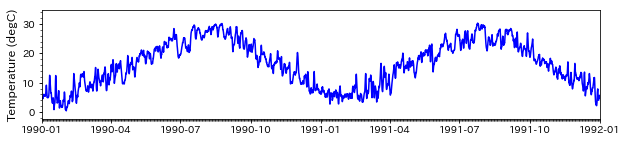

In [52]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
### xlim = (parse("2014-01-15"), parse("2014-02-16"))  ### ex. for datetime
xlim = None
ylim = None
plot_config = Data1D_PlotConfig(xlim = xlim, ylim = ylim, x_minor_locator = DayLocator(interval=1), y_minor_locator = MultipleLocator(2), \
                                format_xdata = DateFormatter('%Y-%m-%d'), ylabel = 'Temperature (degC)')
Plot1D(plot_config, data, window=25).save_plot('data.png', dpi=600)

## Example of vector plot

In [53]:
wind = Data1D(df, 'u', 'v')
print(wind.v[0:10])

[4.3        4.2588366  4.29274845 4.4        3.19339402 2.16973855
 1.7        1.82726268 2.92213773 4.3       ]


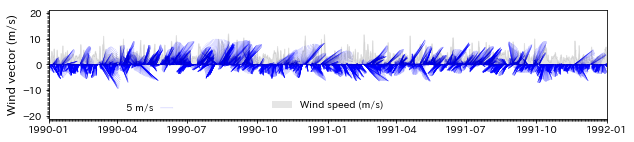

In [54]:
#xlim = (parse("2013-12-25 00:00:00"),parse("2014-01-10 00:00:00"))
xlim = None 
ylim = None
plot_config = Data1D_PlotConfig(xlim = xlim, ylim = ylim, x_minor_locator = DayLocator(interval=1), \
                                y_minor_locator = MultipleLocator(0.5), format_xdata = DateFormatter('%Y-%m-%d'), \
                                ylabel = 'Wind vector (m/s)', vlabel='Wind speed (m/s)', vlabel_loc = 'lower center')
Plot1D(plot_config, wind, window=25).save_vector_plot('wind.png', magnitude = True, dpi=600)